In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys
sys.path.append('/nethome/jbang36/eko')


In [3]:
video_name = 'cherry960'

from eko_paper2022.motivation.main import *

images = load_dataset(video_name)

12-01-2022 00:39:57 [info:049]INFO : meta data of the video /srv/data/jbang36/video_data/cherry960/video.mp4 is (100000, 540, 960, 3)
meta data of the video /srv/data/jbang36/video_data/cherry960/video.mp4 is (100000, 540, 960, 3)
100%|██████████| 100000/100000 [01:45<00:00, 947.57it/s]


In [4]:
#### we need to measure each individual timings.... first we get the timings tasti and eko first..
### we will divide into three different portions... (1) ML Inference, (2) Oracle Inference, (3) Others
### for anchor count, let's go with 5 percent of the entire video
### let's start with TASTI

percentage = 0.1
length = len(images)
anchor_count = int(length * percentage)


In [5]:
anchor_count

10000

In [6]:
## through is 
dataset_dict = {'jackson': {'through': 1 / 308, 'resnet': 5 * 60 + 4},
               'cherry960': {'through': 1 / 140, 'resnet': 10*60 + 30},
               'ua_detrac960': {'through': 1 / 140, 'resnet': 8 * 60 + 14},
               'dashcam960': {'through': 1 / 140, 'resnet': 7 * 60 + 35}}

model_dict = {'resnet': {'image_size': 224},
              'svm': {'image_size': 50},
              'tasti': {'image_size': 224},
              'eko': {'image_size': 224}}

through = dataset_dict[video_name]['through']
oracle_time = anchor_count * through
oracle_time_eko = anchor_count * 0.8 * through

In [7]:

from eko_paper2022.motivation.main import execute_ekoalt
from eko_paper2022.experiments.main import *

category = 'car'

eko = execute_ekoalt(images, video_name, category = category, nb_buckets = 5000)
query, times = query_process_aggregate(eko)

a = query.y_pred
b = query.y_true
gt_aggregate = []
for bb in b:
    gt_aggregate.append(float(bb))
gt_aggregate = np.array(gt_aggregate)

index initializing....
number of training instances:  1
mining complete!
training complete!
inferring complete!
0.8 5000
rep indices stats 5000 4000
4001 5000
bucketing complete!


Target DNN Invocations:   0%|          | 0/4001 [00:00<?, ?it/s]

Propagation:   0%|          | 0/100000 [00:00<?, ?it/s]

r 4.0
NightStreetAggregateQuery
---------------------------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
initial_estimate             46193.0
debiased_estimate            45033.8224186375
nb_samples                   733
y_pred                       [          0           0           0 ...           2           2           2]
y_true                       [DNNOutputCacheFloat(idx=0) DNNOutputCacheFloat(idx=1) DNNOutputCacheFloat(idx=2) ... DNNOutputCacheFloat(idx=99997) DNNOutputCacheFloat(idx=99998) DNNOutputCacheFloat(idx=99999)]
actual_estimate              46259.0


In [7]:
images.shape

(300000, 300, 300, 3)

### Model Index Construction Times


### SVM

In [ ]:
/Users/KkaKkoong/Repos/eko/benchmarks/stanford/tasti/tasti/query.py

In [8]:
from eko_paper2022.motivation.main import *

from eko_paper2022.experiments.svm_wrapper import SVMWrapper


svm_wrapper = SVMWrapper()
labels = gt_aggregate

st = time.perf_counter()
svm_wrapper.train(images, labels)
et  = time.perf_counter()

print('training time', et - st)

st = time.perf_counter()
svm_aggregate = svm_wrapper.inference_aggregate(images)
et = time.perf_counter()

print('inference time', et - st)


SVM training start....
SVM training done!!
training time 5.072959948331118
total time taken for resizing the images:  1.6230335049331188  seconds
(100000, 2700)


KeyboardInterrupt: 

In [ ]:
### now we move onto performing inference using Resnet-18
import time
st = time.perf_counter()
image_size = model_dict['resnet']['image_size']
execute_resnet(images, image_size)
et = time.perf_counter()


In [ ]:
print(category)


st = time.perf_counter()
images.shape
### load the labels -- it's loading the csv file
if category != 'car':
    label_file = f'/srv/data/jbang36/video_data/{video_name}/tasti_labels_{category}.csv'
else:
    label_file = f'/srv/data/jbang36/video_data/{video_name}/tasti_labels.csv'

from eko_paper2022.experiments.resnet_wrapper import ResnetWrapper

print(label_file)

resnet = ResnetWrapper()

labels = resnet._load_labels(images, label_file, category)


resnet.train(images, labels)
et = time.perf_counter()
print('total training time', et - st)

In [ ]:
st = time.perf_counter()
resnet_aggregate = resnet.inference_aggregate(images, image_size = 224)
et = time.perf_counter()

print('inference time', et - st)

In [14]:
anchor_count

10000

In [15]:
anchor_count / 140

71.42857142857143

In [17]:
### eko
st = time.perf_counter()
execute_ekoalt(images, video_name, nb_buckets = anchor_count)
et = time.perf_counter()
et - st

index initializing....
number of training instances:  1
mining complete!
training complete!
inferring complete!
0.8 10000
rep indices stats 10000 8334
8335 10000
bucketing complete!


Target DNN Invocations:   0%|          | 0/8335 [00:00<?, ?it/s]

0.9772926010191441

In [17]:
len(images)

74880

In [33]:
anchor_count = 300000 * 0.1
through = 1 / 140

In [34]:
anchor_count

30000.0

In [35]:
oracle_time = anchor_count * through
oracle_time_eko = anchor_count * 0.8 * through

In [36]:
oracle_time

214.28571428571428

In [37]:
oracle_time_eko

171.42857142857142

In [1]:
### collect the results here
### ML inference, Others, Oracle inference -- Training is too subjective in my opinion....
['ML Training', 'ML Inference', 'Other', 'Oracle Inference']

cherry_svm = [14.2 + 100000 * 0.01 / 140, 136.05, 0, 0]
cherry_resnet = [11.7 + 100000 * 0.01 / 140, 6 * 60 + 50, 0, 0]
cherry_tasti = [0, 6 * 60 + 50, 456 - (6 * 60 + 50), 71.4]
cherry_eko = [0, 0, 1.3, 57.1]

detrac_svm = [14.2 + 87000 * 0.01 / 140, 100.5, 0, 0]
detrac_resnet = [11.7 + 87000 * 0.01 / 140, 5* 60 + 38, 0, 0]
detrac_tasti = [0, 5 * 60 +38, 373 - (5 * 60 + 38), 59.8]
detrac_eko = [0, 0, 4.2, 47.8]

dashcam_svm = [14.2 + 76000 * 0.01 / 140, 73, 0, 0]
dashcam_resnet = [11.7 + 76000 * 0.01 / 140, 5 * 60 + 40, 0, 0]
dashcam_tasti = [0, 5 * 60 + 40, 339.7 - (5 * 60 + 8), 53.4]
dashcam_eko = [0, 0, 1.8, 42.8]

r_time = 9*60 + 16
jackson_svm = [14.2 + 300000 * 0.01 / 140, 1116, 0, 0]
jackson_resnet = [11.7 + 300000 * 0.01 / 140, r_time, 0, 0]
jackson_tasti = [0, r_time, 1054 - r_time, 214.3]
jackson_eko = [0, 0, 2.7, 171.4]




In [2]:
### rearrange to split svm and resnet

['ML Training', 'SVM', 'Resnet', 'Other', 'YOLOv5']

cherry_svm = [14.2 + 100000 * 0.01 / 140, 136.05, 0, 0, 0]
cherry_resnet = [11.7 + 100000 * 0.01 / 140, 0, 6 * 60 + 50, 0, 0]
cherry_tasti = [0, 0, 6 * 60 + 50, 456 - (6 * 60 + 50), 71.4]
cherry_eko = [0, 0,0,  1.3, 57.1]

detrac_svm = [14.2 + 87000 * 0.01 / 140, 100.5, 0,  0, 0]
detrac_resnet = [11.7 + 87000 * 0.01 / 140, 0, 5* 60 + 38, 0, 0]
detrac_tasti = [0, 0, 5 * 60 +38, 373 - (5 * 60 + 38), 59.8]
detrac_eko = [0,0,  0, 4.2, 47.8]

dashcam_svm = [14.2 + 76000 * 0.01 / 140, 73, 0,  0, 0]
dashcam_resnet = [11.7 + 76000 * 0.01 / 140,0,  5 * 60 + 40, 0, 0]
dashcam_tasti = [0, 0, 5 * 60 + 40, 339.7 - (5 * 60 + 8), 53.4]
dashcam_eko = [0, 0, 0, 1.8, 42.8]

r_time = 9*60 + 16
jackson_svm = [14.2 + 300000 * 0.01 / 140, 1117, 0,  0, 0]
jackson_resnet = [11.7 + 300000 * 0.01 / 140, 0, r_time, 0, 0]
jackson_tasti = [0, 0, r_time, 1054 - r_time, 214.3]
jackson_eko = [0, 0, 0, 2.7, 171.4]

len(cherry_svm), len(cherry_resnet), len(cherry_eko), len(cherry_tasti)


(5, 5, 5, 5)

In [48]:
cherry_resnet

[18.84285714285714, 0, 410, 0, 0]

In [49]:
cherry_tasti

[0, 0, 410, 46, 71.4]

In [51]:
cherry_svm

[21.34285714285714, 136.05, 0, 0, 0]

In [53]:
cherry_resnet

[18.84285714285714, 0, 410, 0, 0]

In [50]:
410 / 71.4

5.742296918767506

In [46]:
sum(cherry_svm), sum(cherry_resnet), sum(cherry_tasti)

(157.39285714285717, 428.84285714285716, 527.4)

In [47]:
424 / 157, 527 / 428

(2.700636942675159, 1.2313084112149533)

In [21]:
cherry_svm

[21.34285714285714, 136.05, 0, 0, 0]

In [3]:
i = 0
cherry_train = [cherry_svm[i], cherry_resnet[i], cherry_tasti[i], cherry_eko[i]]
i = 1
cherry_svm2 = [cherry_svm[i], cherry_resnet[i], cherry_tasti[i], cherry_eko[i]]
i = 2
cherry_resnet2 = [cherry_svm[i], cherry_resnet[i], cherry_tasti[i], cherry_eko[i]]
i = 3
cherry_other = [cherry_svm[i], cherry_resnet[i], cherry_tasti[i], cherry_eko[i]]
i = 4
cherry_oracle = [cherry_svm[i], cherry_resnet[i], cherry_tasti[i], cherry_eko[i]]



i = 0
detrac_train = [detrac_svm[i], detrac_resnet[i], detrac_tasti[i], detrac_eko[i]]
i = 1
detrac_svm2 = [detrac_svm[i], detrac_resnet[i], detrac_tasti[i], detrac_eko[i]]
i = 2
detrac_resnet2 = [detrac_svm[i], detrac_resnet[i], detrac_tasti[i], detrac_eko[i]]
i = 3
detrac_other = [detrac_svm[i], detrac_resnet[i], detrac_tasti[i], detrac_eko[i]]
i = 4
detrac_oracle = [detrac_svm[i], detrac_resnet[i], detrac_tasti[i], detrac_eko[i]]

i = 0
dashcam_train = [dashcam_svm[i], dashcam_resnet[i], dashcam_tasti[i], dashcam_eko[i]]
i = 1
dashcam_svm2 = [dashcam_svm[i], dashcam_resnet[i], dashcam_tasti[i], dashcam_eko[i]]
i = 2
dashcam_resnet2 = [dashcam_svm[i], dashcam_resnet[i], dashcam_tasti[i], dashcam_eko[i]]
i = 3
dashcam_other = [dashcam_svm[i], dashcam_resnet[i], dashcam_tasti[i], dashcam_eko[i]]
i = 4
dashcam_oracle = [dashcam_svm[i], dashcam_resnet[i], dashcam_tasti[i], dashcam_eko[i]]

i = 0
jackson_train = [jackson_svm[i], jackson_resnet[i], jackson_tasti[i], jackson_eko[i]]
i = 1
jackson_svm2 = [jackson_svm[i], jackson_resnet[i], jackson_tasti[i], jackson_eko[i]]
i = 2
jackson_resnet2 = [jackson_svm[i], jackson_resnet[i], jackson_tasti[i], jackson_eko[i]]
i = 3
jackson_other = [jackson_svm[i], jackson_resnet[i], jackson_tasti[i], jackson_eko[i]]
i = 4
jackson_oracle = [jackson_svm[i], jackson_resnet[i], jackson_tasti[i], jackson_eko[i]]

<ipython-input-4-52af70861331>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(x_axis_names, rotation = 30, ha = 'right',rotation_mode='anchor')
<ipython-input-4-52af70861331>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
<ipython-input-4-52af70861331>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
<ipython-input-4-52af70861331>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


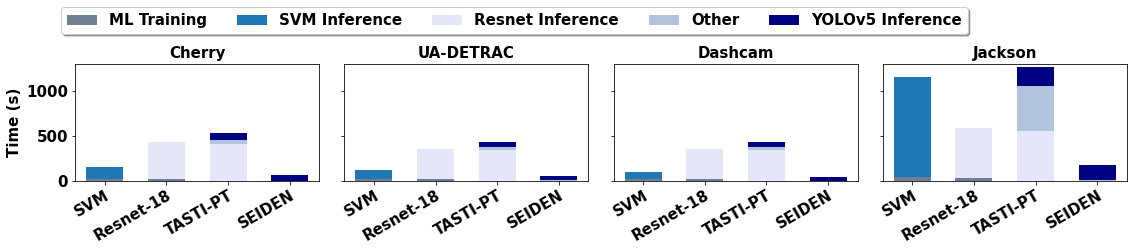

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=15)


x_axis_names = ['SVM', 'Resnet-18', 'TASTI-PT', 'SEIDEN']

x = np.arange(len(x_axis_names))


### we need to do subplots
rows = 1
columns = 4
fig_size = (16, 3.2)
fig, axes = plt.subplots(rows, columns, sharey=True, sharex=True, figsize=fig_size)


i = 0
j = 0
width = 0.6

axes[i].bar(x_axis_names, cherry_train, width, label='ML Training', color = 'slategray')
axes[i].bar(x_axis_names, cherry_svm2, width, bottom = cherry_train, label='SVM Inference')
axes[i].bar(x_axis_names, cherry_resnet2, width, bottom = [a+b for a,b in zip(cherry_train,cherry_svm2)], label='Resnet Inference', color = 'lavender')
axes[i].bar(x_axis_names, cherry_other, width, bottom=[a+b+c for a,b,c in zip(cherry_train, cherry_svm2, cherry_resnet2)], label='Other', color = 'lightsteelblue')
axes[i].bar(x_axis_names, cherry_oracle, width, bottom=[a+b+c+d for a,b,c,d in zip(cherry_train, cherry_svm2, cherry_resnet2, cherry_other)], label='YOLOv5 Inference', color= 'navy')
axes[i].set_ylabel('Time (s)', weight = 'bold', size = 15)
axes[i].set_ylim(0, 1300)
axes[i].set_yticks([0, 500, 1000])

axes[i].set_xticklabels(x_axis_names, rotation = 30, ha = 'right',rotation_mode='anchor')
#plt.ylim(0, 2)
#plt.xticks(x, x_axis_names)
axes[i].set_title('Cherry', weight = 'bold', size = 15)


i = 1
j = 1

axes[i].bar(x_axis_names, detrac_train, width, label='ML Training', color = 'slategray')
axes[i].bar(x_axis_names, detrac_svm2, width, bottom = detrac_train, label='SVM Inference')
axes[i].bar(x_axis_names, detrac_resnet2, width, bottom = [a+b for a,b in zip(detrac_train,detrac_svm2)], label='Resnet Inference', color = 'lavender')
axes[i].bar(x_axis_names, detrac_other, width, bottom=[a+b+c for a,b,c in zip(detrac_train, detrac_svm2, detrac_resnet2)], label='Other', color = 'lightsteelblue')
axes[i].bar(x_axis_names, detrac_oracle, width, bottom=[a+b+c+d for a,b,c,d in zip(detrac_train, detrac_svm2, detrac_resnet2, detrac_other)], label='YOLOv5 Inference', color= 'navy')
axes[i].set_title('UA-DETRAC', weight = 'bold', size = 15)
axes[i].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


i = 2
j = 0


axes[i].bar(x_axis_names, dashcam_train, width, label='ML Training', color = 'slategray')
axes[i].bar(x_axis_names, dashcam_svm2, width, bottom = dashcam_train, label='SVM Inference')
axes[i].bar(x_axis_names, dashcam_resnet2, width, bottom = [a+b for a,b in zip(dashcam_train,dashcam_svm2)], label='Resnet Inference', color = 'lavender')
axes[i].bar(x_axis_names, dashcam_other, width, bottom=[a+b+c for a,b,c in zip(dashcam_train, dashcam_svm2, dashcam_resnet2)], label='Other', color = 'lightsteelblue')
axes[i].bar(x_axis_names, dashcam_oracle, width, bottom=[a+b+c+d for a,b,c,d in zip(dashcam_train, dashcam_svm2, dashcam_resnet2, dashcam_other)], label='YOLOv5 Inference', color= 'navy')
axes[i].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')



axes[i].set_title('Dashcam', weight = 'bold', size = 15)


i = 3
j = 1


axes[i].bar(x_axis_names, jackson_train, width, label='ML Training', color = 'slategray')
axes[i].bar(x_axis_names, jackson_svm2, width, bottom = jackson_train, label='SVM Inference')
axes[i].bar(x_axis_names, jackson_resnet2, width, bottom = [a+b for a,b in zip(jackson_train,jackson_svm2)], label='Resnet Inference', color = 'lavender')
axes[i].bar(x_axis_names, jackson_other, width, bottom=[a+b+c for a,b,c in zip(jackson_train, jackson_svm2, jackson_resnet2)], label='Other', color = 'lightsteelblue')
axes[i].bar(x_axis_names, jackson_oracle, width, bottom=[a+b+c+d for a,b,c,d in zip(jackson_train, jackson_svm2, jackson_resnet2, jackson_other)], label='YOLOv5 Inference', color= 'navy')


axes[i].set_title('Jackson', weight = 'bold', size = 15)
axes[i].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


fig.tight_layout()



lgd = axes[0].legend(loc='upper center', bbox_to_anchor=(1.8, 1.55),
          fancybox=True, shadow=True, ncol=10)

#plt.legend()
plt.savefig('plots/index-construction2.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


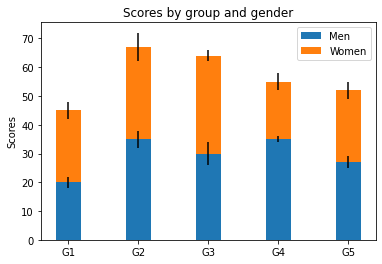

In [19]:
### now we need to draw the thing.

import matplotlib.pyplot as plt

labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 35, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]
men_std = [2, 3, 4, 1, 2]
women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, width, yerr=men_std, label='Men')
ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
       label='Women')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()



In [17]:
### Mini Experiment -- throughput difference between 960x540 images inference as is vs resize to 224x224 then inference

image_size = None
st = time.perf_counter()
execute_resnet(images, image_size)
et = time.perf_counter()

inference image size is  None
cuda


  1%|          | 79/12500 [00:06<16:02, 12.91it/s] 


KeyboardInterrupt: 

In [18]:

image_size = 224
st = time.perf_counter()
execute_resnet(images, image_size)
et = time.perf_counter()

inference image size is  224
cuda


  6%|▋         | 804/12500 [00:26<06:26, 30.24it/s]


KeyboardInterrupt: 

In [15]:
images.shape

(100000, 540, 960, 3)